In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sax
from simphony.libraries import siepic, sipann
from simphony.classical import ClassicalSim
from functools import partial








INFO:tensorflow:Restoring parameters from c:\Users\akhil\Miniconda3\Lib\site-packages\SiPANN\ANN\TIGHT_ANGLE_GAP/model
INFO:tensorflow:Restoring parameters from c:\Users\akhil\Miniconda3\Lib\site-packages\SiPANN\ANN\TIGHT_ANGLE_STRAIGHT/model
INFO:tensorflow:Restoring parameters from c:\Users\akhil\Miniconda3\Lib\site-packages\SiPANN\ANN\TIGHT_ANGLE_BENT_RAND/model


In [17]:
wl = np.linspace(1.5, 1.6, 10)
ar=[0,0.15,0.25,0.4,0.5,0.6,0.75,0.9,1]


def wg_ph(wl=wl,phase=0.25):
    wgp, info = sax.circuit(
            netlist={
                "instances": {
                    "waveg_1": "waveguide",                 
                    },
                "connections": {  },
            
                "ports": {
                    "in_t":"waveg_1,o0",
                
                    "out_t":"waveg_1,o1",
                
                    }
                },
            models={
                "waveguide":partial(siepic.waveguide,width=500, length=10000),
                
                }
                )

    # need to first recover the effective index
    # Return the composite model.
    #deln = 0.000155*phase*2*np.pi*10000/wl
    deln = phase*2*np.pi
    val = wgp(wl = wl)
    #print((np.cos(deln) + 1j*np.sin(deln)))
    val[('in_t', 'out_t')] = val[('in_t', 'out_t')] * (np.cos(deln) + 1j*np.sin(deln))
    val[('out_t', 'in_t')] = val[('out_t', 'in_t')] * (np.cos(deln) + 1j*np.sin(deln))
    return val

In [18]:
cir, info = sax.circuit(
        netlist={
            "instances": {
                "stdcpl1":"standard_coupler",
                "waveg_t": "wg_ph",
                "waveg_b": "waveguide",
                },
            "connections": {  "waveg_t,out_t":"stdcpl1,o0",
            "waveg_b,o1":"stdcpl1,o1",
           },
        
            "ports": {
                "int":"waveg_t,in_t",
                "inb":"waveg_b,o0",
                "outt":"stdcpl1,o2",
                "outb":"stdcpl1,o3",
                }
            },
        models={
            "waveguide": partial(siepic.waveguide, width=500, length=10000),
            "standard_coupler":partial(sipann.standard_coupler, length=6363, horizontal=5000, vertical=2500),
             "wg_ph": partial(wg_ph, wl=wl)
            }
            )

# need to first recover the effective index
# Return the composite model.
#deln = 0.000155*phase*2*np.pi*10000/wl


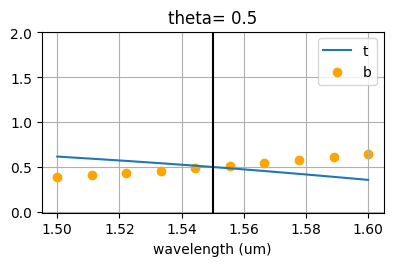

In [23]:
k=1
ar=[0.5]
f=plt.figure()
f.set_figheight(8)
f.set_figwidth(15)
for i in ar:

    sim = ClassicalSim(ckt=cir, wl=wl, phase=i)
    laser_t = sim.add_laser(ports=["int"], power=1.0)
    laser_b = sim.add_laser(ports=["inb"], power=
                            0)
    detector_t = sim.add_detector(ports=["outt"])
    detector_b = sim.add_detector(ports=["outb"])
    result = sim.run()


 
    plt.subplot(3,3,k)
   
    plt.plot(wl, np.abs(result.sdict['outt'])**2, label='t')
    plt.scatter(wl, np.abs(result.sdict['outb'])**2, label='b',color='orange')
    plt.axvline(x=1.55, color='k')
    plt.legend()
    plt.grid()
    plt.title("theta= "+ str(i))
    plt.ylim([-0.01,2.01])
    plt.xlabel("wavelength (um)")
    k=k+1
    

<Axes: xlabel='Wavelength (um)', ylabel='Power (mW)'>

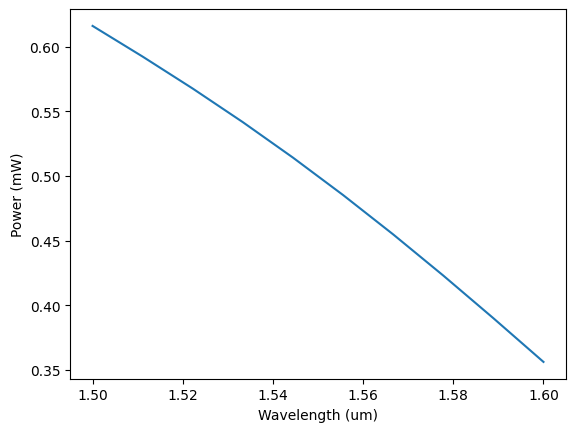

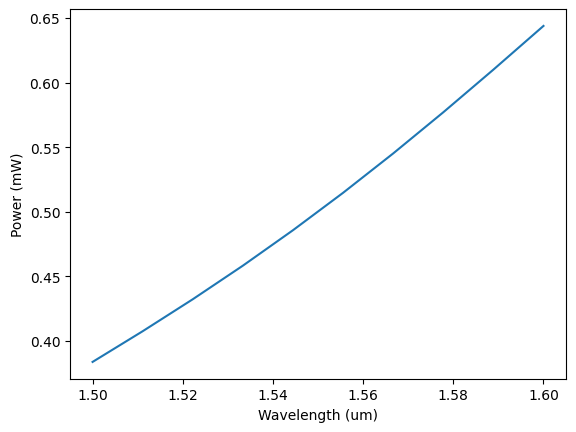

In [24]:
result.detectors["outt"].plot()
result.detectors["outb"].plot()

In [21]:
print(result)

ClassicalResult(wl=Array([1.5       , 1.51111111, 1.52222222, 1.53333333, 1.54444444,
       1.55555556, 1.56666667, 1.57777778, 1.58888889, 1.6       ],      dtype=float64), sdict={'outt': Array([ 0.36605477+0.93059331j, -0.63663479+0.77116544j,
       -0.96817647+0.25026852j, -0.89840947+0.43915877j,
        0.291828  +0.95647081j, -0.14730506-0.98909111j,
        0.93235395-0.36154684j,  0.25534808-0.96684919j,
        0.17395404+0.98475377j,  0.4165394 +0.90911767j],      dtype=complex128), 'outb': Array([-0.36605477-0.93059331j,  0.63663479-0.77116544j,
        0.96817647-0.25026852j,  0.89840947-0.43915877j,
       -0.291828  -0.95647081j,  0.14730506+0.98909111j,
       -0.93235395+0.36154684j, -0.25534808+0.96684919j,
       -0.17395404-0.98475377j, -0.4165394 -0.90911767j],      dtype=complex128)}, detectors={'outt': <simphony.classical.Detector object at 0x000001F250085C40>, 'outb': <simphony.classical.Detector object at 0x000001F200168860>})


In [6]:
Sdict=result.sdict   #assuming that sim.run() populates results.sdict with s -parameters
print(Sdict.keys())

dict_keys(['outt', 'outb'])
